After having discussed the 2D potential flow problem in a [previous blog post](http://flothesof.github.io/2D-potential-flow-finite-differences.html) (and having achieved less than ideal results), I thought it would be nice to discuss it in the context of the finite element method, a technique I have been thinking about for years.

As a recap, here's the problem we're trying to solve:

# Meshing a circle

After a quick google search, I've found many possible libraries to use from to perform a 2D mesh of the problem at hand. I've discounted the reference [`scipy.spatial.Delaunay`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html) because it seems that it doesn't handle holes in the mesh in favor of a Python wrapper for triangle, a [C library by Jonathan Shewchuck](https://www.cs.cmu.edu/~quake/triangle.demo.html), called [`triangle`](https://rufat.be/triangle/examples.html). Adapting an example from the libarary, let's see what we get:

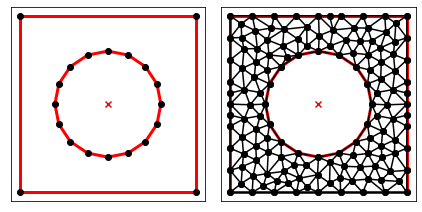

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import triangle as tr


def box(Lx, Ly):
    """Create a box out of four points."""
    A = np.array([-Lx/2, Ly/2])
    B = np.array([Lx/2, Ly/2])
    C = np.array([Lx/2, -Ly/2])
    D = np.array([-Lx/2, -Ly/2])
    pts = np.vstack([A, B, C, D])
    seg = np.array([[0, 1], [1, 2], [2, 3], [3, 0]])
    return pts, seg


def circle(N, R):
    """Create a (closed) circle with radius R and N points."""
    i = np.arange(N)
    theta = i * 2 * np.pi / N
    pts = np.stack([np.cos(theta), np.sin(theta)], axis=1) * R
    seg = np.stack([i, i + 1], axis=1) % N
    return pts, seg

Lx, Ly = 2., 2.
pts0, seg0 = box(Lx, Ly)
pts1, seg1 = circle(16, 0.6)
pts = np.vstack([pts0, pts1])
seg = np.vstack([seg0, seg1 + seg0.shape[0]])

A = dict(vertices=pts, segments=seg, holes=[[0, 0]])
B = tr.triangulate(A, 'qpa0.02')
tr.compare(plt, A, B)
plt.show()

Great! This allows us to generate meshes in an easy way. Let's also test some of the visualization at our disposal.

First, let's make a random field that takes a value for each node of the mesh:

In [2]:
random_field = np.random.rand(B['vertices'].shape[0])

We can write a .vtk file using `meshio` and the mesh informations of its `vertices` and `triangles`:

In [3]:
import meshio

points = B['vertices']
cells = [("triangle", np.atleast_2d(arr)) for arr in B['triangles']]
meshio.write_points_cells(
    "foo.vtk",
    points,
    cells,
    point_data={'random_field': random_field},
)

Finally, we can then read and render the result using `pyvista`:

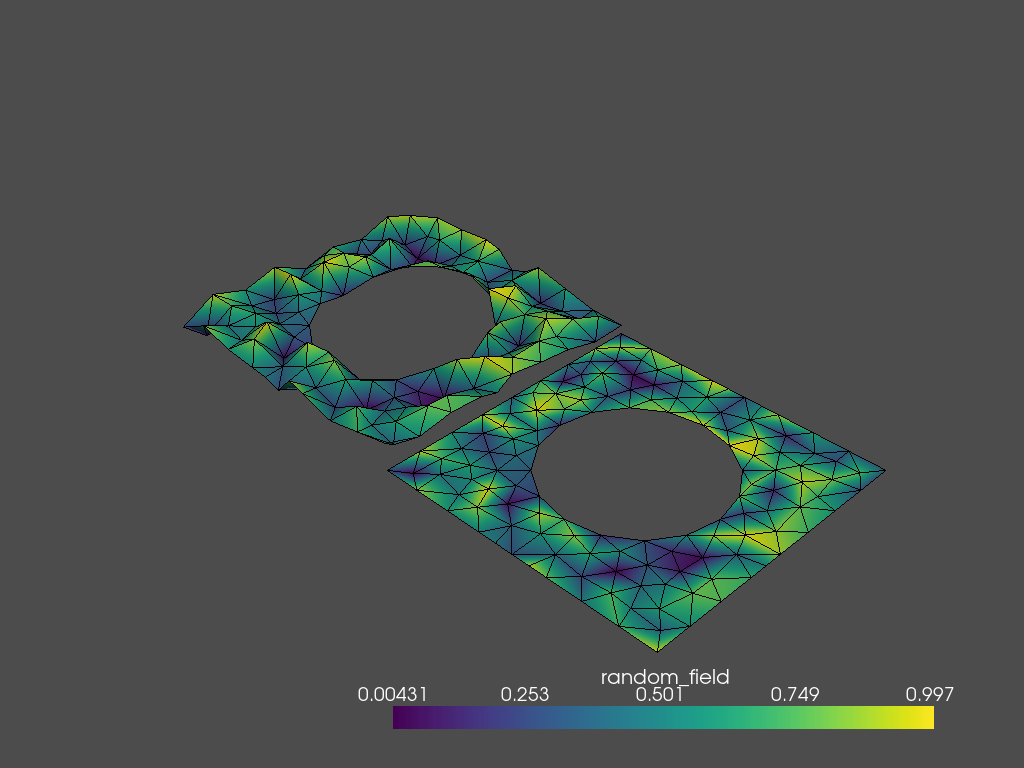

[(4.992979811057987, 5.992979811057987, 5.0927262767409704),
 (0.0, 1.0, 0.0997464656829834),
 (0.0, 0.0, 1.0)]

In [4]:
import pyvista

mesh = pyvista.read('foo.vtk')
shifted = mesh.copy()
shifted.translate([0, 2, 0])

p = pyvista.Plotter()
p.add_mesh(mesh.warp_by_scalar(factor=0.2), show_edges=True)
p.add_mesh(shifted, show_edges=True)
p.show()

# Assembling the stiffness matrix 

Let's first extract some important fields from the mesh.

In [5]:
triangles = B['triangles']
vertices = B['vertices']
vertex_markers = B['vertex_markers']

possible_edges = (vertex_markers == 1).flatten()
EPS = 1e-10
for vertex_index in np.nonzero(possible_edges)[0]:
    if abs(vertices[vertex_index][0] - Lx/2.) < EPS:
        vertex_markers[vertex_index] = 2
    elif abs(vertices[vertex_index][0] + Lx/2.) < EPS:
        vertex_markers[vertex_index] = 2
    elif abs(vertices[vertex_index][1] - Ly/2.) < EPS:
        vertex_markers[vertex_index] = 2
    elif abs(vertices[vertex_index][1] + Ly/2.) < EPS:
        vertex_markers[vertex_index] = 2

Let's build a dictionary mapping from node to triangles of which it is part.

In [6]:
from collections import defaultdict

node2triangle = defaultdict(list)
for element_index, triangle in enumerate(triangles):
    for node in triangle:
        node2triangle[node].append(element_index)

triangle2node = defaultdict(list)
for element_index, triangle in enumerate(triangles):
    for node in triangle:
        triangle2node[element_index].append(node)

Let's plot some things.

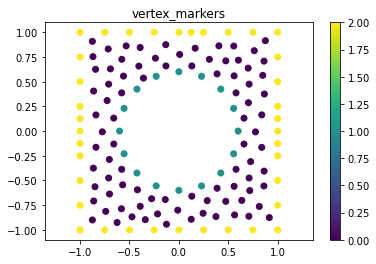

In [7]:
fig, ax = plt.subplots()
m = ax.scatter(vertices[:, 0], vertices[:, 1], c=vertex_markers)
ax.set_title('vertex_markers')
plt.colorbar(m)
ax.axis('equal');

In [8]:
def plot_triangle(ax, vertices, triangles, which_triangle=None, show_labels=False):
    """Plots a triangulation, with or without labels."""
    if which_triangle is None:
        for triangle in triangles:
            pts = vertices[triangle, :]
            pts = np.r_[(pts, pts[0].reshape(1, -1))]
            ax.plot(pts[:, 0], pts[:, 1], '-k', alpha=0.5)
            if show_labels:
                for n in triangle:
                    ax.text(*vertices[n], n)
    else:
        for triangle in triangles[which_triangle]:
            pts = vertices[triangle, :]
            pts = np.r_[(pts, pts[0].reshape(1, -1))]
            ax.plot(pts[:, 0], pts[:, 1], '-k', alpha=0.5)
            if show_labels:
                for n in triangle:
                    ax.text(*vertices[n], n)

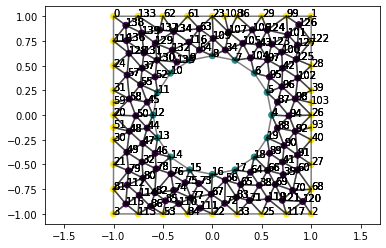

In [9]:
fig, ax = plt.subplots()
plot_triangle(ax, vertices, triangles, show_labels=True)
ax.scatter(vertices[:, 0], vertices[:, 1], c=vertex_markers)
ax.axis('equal');

In [10]:
def shape_element_integrals(x1, y1, x2, y2, x3, y3):
    """Returns all shape integrals over element."""
    A = 1/2 * (x2 * y3 - x3 * y2 + x3 * y1 - x1 * y3 + x1 * y2 - x2 * y1)
    b1 = y2 - y3
    b2 = y3 - y1
    b3 = y1 - y2
    c1 = x3 - x2
    c2 = x1 - x3
    c3 = x2 - x1
    a11 = (b1**2 + c1**2) / (4 * A)
    a12 = (b2 * b1 + c2 * c1) / (4 * A)
    a13 = (b3 * b1 + c3 * c1) / (4 * A)
    a22 = (b2**2 + c2**2) / (4 * A)
    a23 = (b3 * b2 + c3 * c2) / (4 * A)
    a33 = (b3**2 + c3**2) / (4 * A)
    return np.array([[a11, a12, a13],
                     [a12, a22, a23],
                     [a13, a23, a33]])

def shape_element_integrals_boundary(x1, y1, x2, y2, h1, h2):
    """Computes boundary contribution."""
    delta_s = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    b1 = 1/6. * delta_s * (2 * h1 + h2)
    b2 = 1/6. * delta_s * (h1 + 2 * h2)
    return np.array([b1, b2])

U0 = np.array([1., 0.])

N = vertices.shape[0]

a_matrix = np.zeros((N, N))
b_matrix = np.zeros((N,))

for test_function_node in range(N):
    concerned_triangles = node2triangle[test_function_node]
    for other_triangle in concerned_triangles:
        other_triangle_nodes = triangle2node[other_triangle]
        integrals = shape_element_integrals(*vertices[other_triangle_nodes].flatten())
        local_index = other_triangle_nodes.index(test_function_node)
        for other_node_local_index, other_node in enumerate(other_triangle_nodes):
            a_matrix[test_function_node, other_node] += integrals[local_index, other_node_local_index]
            #print(f"{test_function_node} (local:{local_index}) ->{other_node} (local:{other_node_local_index})")

        # exterior boundary
        if vertex_markers[test_function_node] == 2: 
            local_tags = vertex_markers[other_triangle_nodes]
            # we need at least two nodes to be on the boundary
            if local_tags[local_tags == 2].size == 1:
                pass
            elif local_tags[local_tags == 2].size == 2:
                if local_tags.flatten().tolist() == [2, 2, 0]:
                    first = 0
                    second = 1
                elif local_tags.flatten().tolist() == [0, 2, 2]:
                    first = 1
                    second = 2
                elif local_tags.flatten().tolist() == [2, 0, 2]:
                    first = 2
                    second = 0
                else:
                    raise NotImplementedError
                first_pt = vertices[first]
                second_pt = vertices[second]
                vec = second_pt - first_pt 
                t = vec / np.linalg.norm(vec)
                n = np.array([t[1], -t[0]])
                assert np.allclose(np.linalg.norm(n), 1.)
                udotn = np.sum(U0 * n)
                print(udotn)
                boundary_integrals = shape_element_integrals_boundary(*vertices[(first, second), :].flatten(), udotn, udotn)
                print(boundary_integrals)
                if sum(np.isnan(boundary_integrals)):
                    raise ValueError
                b_matrix[test_function_node] += boundary_integrals[[first, second].index(local_index)]
            else:
                raise NotImplementedError

0.0
[0. 0.]
0.7071067811865475
[1. 1.]
-1.0
[-1. -1.]
0.0
[0. 0.]
-1.0
[-1. -1.]
0.0
[0. 0.]
0.0
[0. 0.]
0.0
[0. 0.]
-1.0
[-1. -1.]
0.7071067811865475
[1. 1.]
0.7071067811865475
[1. 1.]
0.0
[0. 0.]
0.0
[0. 0.]
0.0
[0. 0.]
0.0
[0. 0.]
0.0
[0. 0.]
0.7071067811865475
[1. 1.]
0.0
[0. 0.]
0.7071067811865475
[1. 1.]
0.0
[0. 0.]
0.0
[0. 0.]
-1.0
[-1. -1.]
-1.0
[-1. -1.]
0.7071067811865475
[1. 1.]
0.7071067811865475
[1. 1.]
0.0
[0. 0.]
0.7071067811865475
[1. 1.]
-1.0
[-1. -1.]
0.0
[0. 0.]
0.0
[0. 0.]
0.7071067811865475
[1. 1.]
-1.0
[-1. -1.]
0.0
[0. 0.]
0.0
[0. 0.]
0.7071067811865475
[1. 1.]
-1.0
[-1. -1.]
-1.0
[-1. -1.]
0.0
[0. 0.]
0.7071067811865475
[1. 1.]
-1.0
[-1. -1.]
0.0
[0. 0.]
-1.0
[-1. -1.]
0.0
[0. 0.]
0.0
[0. 0.]
0.7071067811865475
[1. 1.]
-1.0
[-1. -1.]
0.0
[0. 0.]
-1.0
[-1. -1.]
-1.0
[-1. -1.]
-1.0
[-1. -1.]
-1.0
[-1. -1.]
0.0
[0. 0.]
0.7071067811865475
[1. 1.]
0.0
[0. 0.]
0.0
[0. 0.]
0.0
[0. 0.]
0.0
[0. 0.]
-1.0
[-1. -1.]
0.0
[0. 0.]
-1.0
[-1. -1.]
-1.0
[-1. -1.]
-1.0
[-1. -1.]
-

Let's do some sanity-checks:

a is symmetric: True


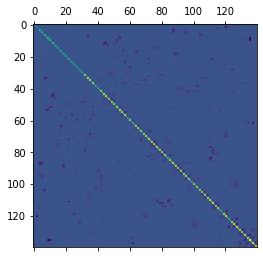

In [11]:
plt.matshow(a_matrix)

print('a is symmetric:', np.allclose(a_matrix, a_matrix.T))

In [12]:
b_matrix

array([ 1.00000000e+00, -1.00000000e+00, -1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.11022302e-16,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  1.00000000e+00, -1.00000000e+00, -1.11022302e-16,
        1.00000000e+00, -1.11022302e-16,  0.00000000e+00, -1.11022302e-16,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.11022302e-16,  0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
       -1.11022302e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
        0.00000000e+00,  

And now, let's solve the system.

In [15]:
solution = np.linalg.solve(a_matrix, b_matrix)

solution

array([-2.5734855e+15, -2.5734855e+15, -2.5734855e+15, -2.5734855e+15,
       -2.5734855e+15, -2.5734855e+15, -2.5734855e+15, -2.5734855e+15,
       -2.5734855e+15, -2.5734855e+15, -2.5734855e+15, -2.5734855e+15,
       -2.5734855e+15, -2.5734855e+15, -2.5734855e+15, -2.5734855e+15,
       -2.5734855e+15, -2.5734855e+15, -2.5734855e+15, -2.5734855e+15,
       -2.5734855e+15, -2.5734855e+15, -2.5734855e+15, -2.5734855e+15,
       -2.5734855e+15, -2.5734855e+15, -2.5734855e+15, -2.5734855e+15,
       -2.5734855e+15, -2.5734855e+15, -2.5734855e+15, -2.5734855e+15,
       -2.5734855e+15, -2.5734855e+15, -2.5734855e+15, -2.5734855e+15,
       -2.5734855e+15, -2.5734855e+15, -2.5734855e+15, -2.5734855e+15,
       -2.5734855e+15, -2.5734855e+15, -2.5734855e+15, -2.5734855e+15,
       -2.5734855e+15, -2.5734855e+15, -2.5734855e+15, -2.5734855e+15,
       -2.5734855e+15, -2.5734855e+15, -2.5734855e+15, -2.5734855e+15,
       -2.5734855e+15, -2.5734855e+15, -2.5734855e+15, -2.5734855e+15,
      

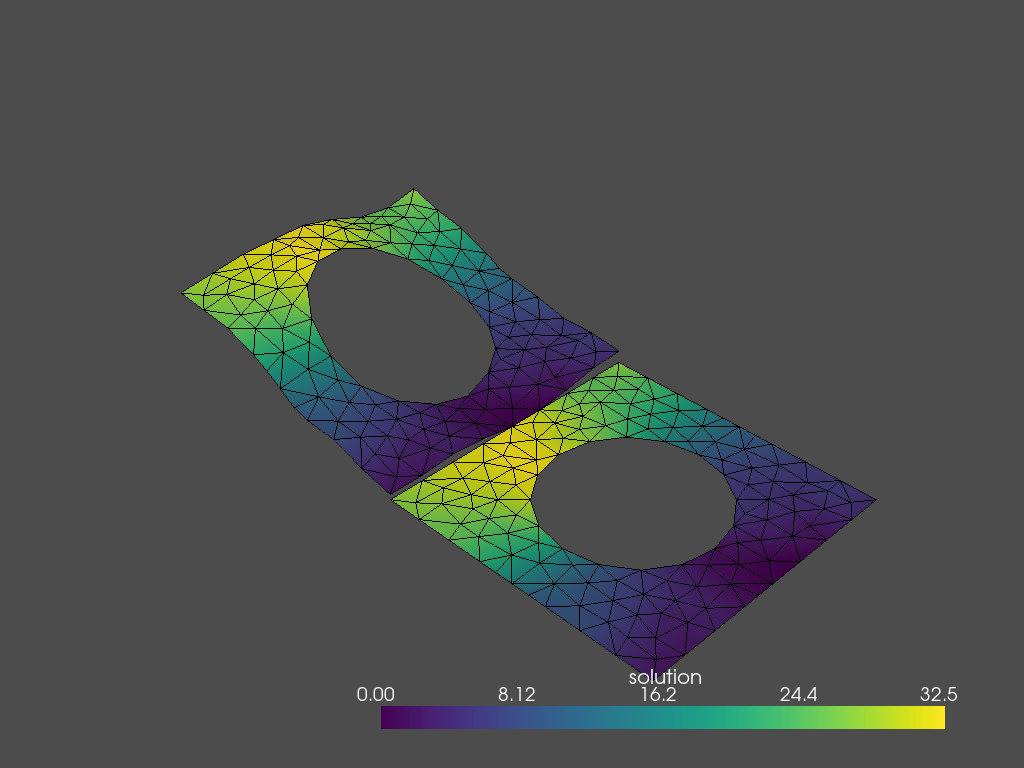

[(5.04043012390486, 6.04043012390486, 5.365430111983931),
 (0.0, 1.0, 0.32499998807907104),
 (0.0, 0.0, 1.0)]

In [16]:
points = B['vertices']
cells = [("triangle", np.atleast_2d(arr)) for arr in B['triangles']]
meshio.write_points_cells(
    "foo.vtk",
    points,
    cells,
    point_data={'solution': solution - solution.min()},
)

mesh = pyvista.read('foo.vtk')
shifted = mesh.copy()
shifted.translate([0, 2, 0])

p = pyvista.Plotter()
p.add_mesh(mesh.warp_by_scalar(factor=0.02), show_edges=True)
p.add_mesh(shifted, show_edges=True)
p.show()